## Quick check analysis notebook

### Imports

In [297]:
import hax
from hax import cuts
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.colors import LogNorm
import time
import datetime

In [298]:
def get_run_list(path, start_at=None, stop_at=None):
    file_list = np.sort(os.listdir(path))
    
    file_list = [file[:-5] for file in file_list if file[-5:]=='.root']
    
    if start_at:
        start_index = np.where(np.array(file_list) == start_at)[0][0]
        file_list = file_list[start_index:]
    if stop_at:
        stop_index = np.where(np.array(file_list) == stop_at)[0][0]
        file_list = file_list[:stop_index+1]
    print('Run list contains %d files' % len(file_list))
    return file_list
    

### Configuration

In [299]:
processed_data_path = '/home/xams/lena/run8/processed/data/'
run_name = '170313_155320imp'

minitree_path = '/home/xams/lena/run8/minitrees/'

# processed_data_path = '/home/xams/lena/run8/processed/baseline/'
# run_name = '170210_093437'

In [316]:
# run_names = get_run_list(processed_data_path, start_at = '170310_151920',
#             stop_at =  '170311_025835')

run_names = ['170313_163555']

In [317]:
hax.init(
    # Always use these lines to tell hax that we don't care about Xe1T
    experiment='XAMS', 
    pax_version_policy='loose', use_runs_db = False,
    # Here come the useful settings
    main_data_paths = [processed_data_path],
    minitree_paths = [minitree_path],
    # raw_data_local_path = raw_data_path         
         )

INFO:hax.__init__] Not looking for datasets in runs db since you put use_runs_db = False


In [318]:
class XAMSProperties(hax.minitrees.TreeMaker):
    __version__ = '0.1.0'
    
    extra_branches = ['peaks.*', 'peaks.range_area_decile*', 
                      'interactions*']
    
    def extract_data(self, event):
        
        peak_types = ['s1', 's2']
        peak_properties = ['area_fraction_top', 'area', 'center_time', 'n_saturated_channels']
        extra_properties = ['range_50p_area', 'range_70p_area']
        all_properties = peak_properties + extra_properties
        result_vars = [_pt + '_' + _pp for _pt in peak_types for _pp in all_properties ]
        result = {k: float('nan') for k in result_vars}
        
        interaction_properties = ['drift_time']
        for _prop in interaction_properties:
            result[_prop] = float('nan')
            
        s1s = []
        s2s = []
        
        for peak in event.peaks:
            if peak.type == 's1':
                s1s.append(peak)
            if peak.type == 's2':
                s2s.append(peak)
        
        s1s = sorted(s1s, key = lambda peak: - peak.area)
        s2s = sorted(s2s, key = lambda peak: - peak.area)

        
        # Now load properies
        result['n_s1s'] = len(event.s1s)
        result['n_s2s'] = len(event.s2s)
        
        
        for peak_name, peak_list in zip(['s1', 's2'], [s1s, s2s]):
            if len(peak_list) == 0:
                continue
            # First peak in list sorted by area
            peak = peak_list[0]
            for _prop in peak_properties:
                result[peak_name + '_' + _prop] = getattr(peak, _prop)
            for i in range(10):
                if ('range_%d0p_area' % i) in extra_properties:
                    result[peak_name + '_' + 'range_%d0p_area' % i] = list(peak.range_area_decile)[i]
        
        if len(s2s) > 1:
            result['largest_other_s2'] = getattr(s2s[1], 'area')
        else:
            result['largest_other_s2'] = 0.
            
        result['drift_time'] = result['s2_center_time'] - result['s1_center_time']
        



#             for peak_type, peak_index in zip(peak_types, [s1,s2]):
#                 for _prop in peak_properties:
#                     result[peak_name + '_' + _prop] = getattr(event.peaks[peak_index], _prop)

#                 if 'range_50p_area' in extra_properties:
#                     result[peak_name + '_' + 'range_50p_area'] = list(event.peaks[peak_pos].range_area_decile)[5]
        
        return result

In [319]:
d = hax.minitrees.load(run_names, ['Fundamentals', XAMSProperties])
len(d)

33894

In [320]:
def get_time(d, run_names):    
    next_run_indices = np.where(np.diff(d['event_number'].values) < 0)[0]
    def num(x):
        return len([a for a in next_run_indices if a<x])
    run_numbers = [num(r) for r in d.index]
    d['run_number'] = run_numbers

    all_timestamps = []
    for run_number, run_name in zip(np.unique(run_numbers), run_names):
        d_sub = d[d['run_number']==run_number]
        all_timestamps.append(
            ((d_sub['event_time'].values - d_sub['event_time'].iloc[0]) * 4) * 1e-9 +
            time.mktime(datetime.datetime.strptime(run_name, "%y%m%d_%H%M%S").timetuple()))

    d['unix_time'] = np.concatenate(all_timestamps)
    d['time_since_start'] = d['unix_time'] - d['unix_time'].iloc[0]
    return d

In [321]:
d = get_time(d, run_names)

### Elementary cuts and plots

Finite s1_area selection: 381 rows removed (98.88% passed)


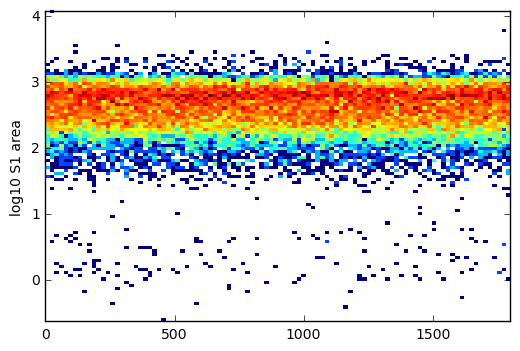

In [322]:
d = cuts.isfinite(d, 's1_area')
plt.hist2d(d['time_since_start'], np.log10(d['s1_area']), 
           bins=100, norm=LogNorm())
plt.ylabel('log10 S1 area')
plt.show()

In [323]:
d = cuts.isfinite(d, 's2_area')
d = cuts.above(d, 'drift_time', 0)

Finite s2_area selection: 2075 rows removed (93.81% passed)
drift_time above 0 selection: 288 rows removed (99.08% passed)


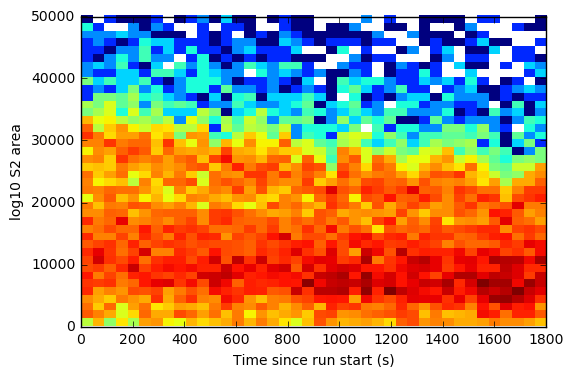

In [329]:

plt.hist2d(d['time_since_start'], (d['s2_area']), 
           bins=40, norm=LogNorm(), range=((0, 1800), (0, 5e4)))
plt.ylabel('log10 S2 area')
plt.xlabel('Time since run start (s)')
plt.savefig('170307_filling.png', bbox_inches='tight')
plt.show()

### Select the good part

In [261]:
# d = d[(d['time_since_start']/3600. > 6) & (d['time_since_start']/3600. < 6.5)]

### Drift time analysis

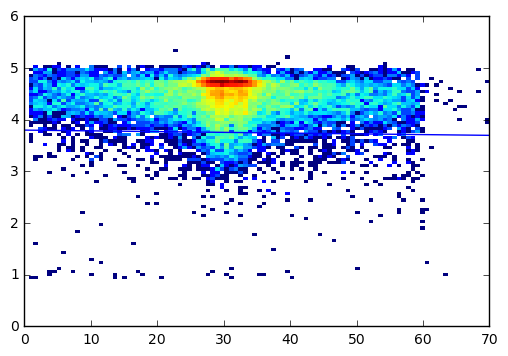

In [263]:
plt.hist2d(d['drift_time'] * 1e-3, np.log10(d['s2_area']), bins=100, norm=LogNorm(), range = ((0,70),(0,6)))
x_plot = np.linspace(0,80, 10)
def exp(x, a0, tau):
    return a0*np.exp(-x/tau)
plt.plot(x_plot, np.log10(exp(x_plot, 10**3.8, 300)))
# plt.axhline(3.8)
plt.show()

drift_time in [25000.0, 36000.0) selection: 9371 rows removed (57.69% passed)


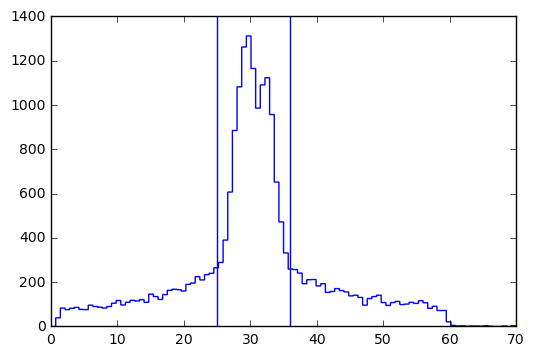

In [264]:
limits = (25e3, 36e3)

plt.hist(d['drift_time'] * 1e-3, bins=100, range=(0,70), histtype='step')
plt.axvline(limits[0]*1e-3)
plt.axvline(limits[1]*1e-3)
d_cs = cuts.range_selection(d, 'drift_time', limits)
plt.show()

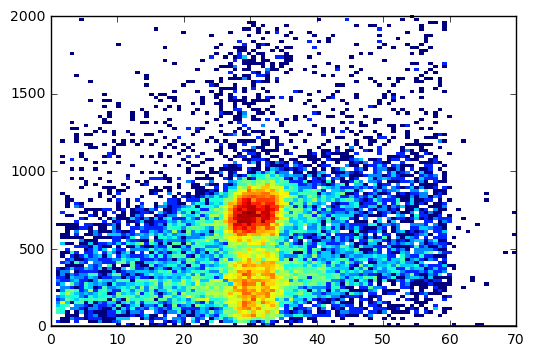

In [265]:
plt.hist2d(d['drift_time'] * 1e-3, d['s1_area'], bins=100, 
           norm=LogNorm(), range = ((0,70),(0,2000)))

plt.plot(x_plot, np.log10(exp(x_plot, 10**3.8, 300)))
# plt.axhline(3.8)
plt.show()

### Electron lifetime & correction

In [266]:
d['s2_area_crappycorr'] = (d['s2_area'] * 
                              np.exp(d['drift_time']*1e-3 / 300))

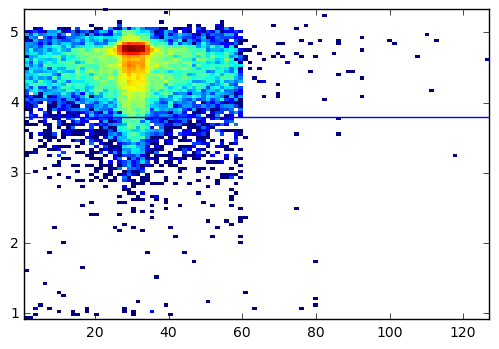

In [267]:
plt.hist2d(d['drift_time'] * 1e-3, np.log10(d['s2_area_crappycorr']), bins=100, norm=LogNorm(),
          )
x_plot = np.linspace(0,80, 10)
def exp(x, a0, tau):
    return a0*np.exp(-x/tau)
#plt.plot(x_plot, np.log10(exp(x_plot, 10**3.8, 22)))
plt.axhline(3.8)
plt.show()

### Saturation check

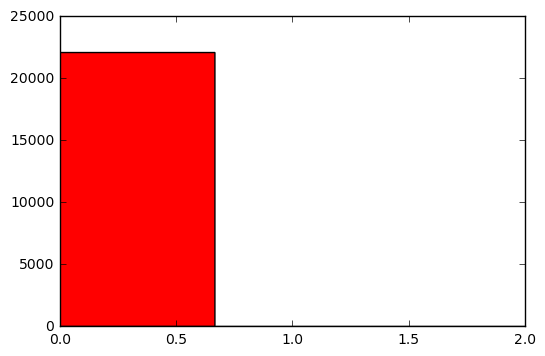

[  2.20900000e+04   5.40000000e+01   5.00000000e+00]


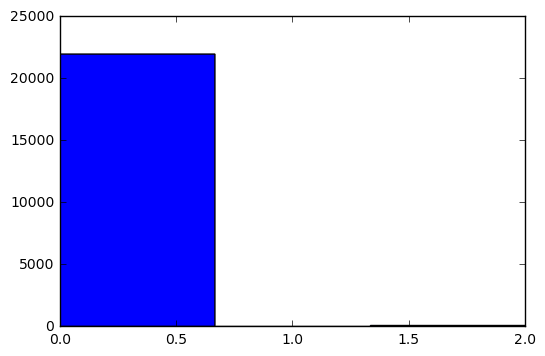

[ 21965.     76.    108.]


In [268]:
a = plt.hist(d['s1_n_saturated_channels'], range=(0,2), bins=3, color = 'red')
# plt.yscale('log')
plt.show()
print(a[0])
b = plt.hist(d['s2_n_saturated_channels'], range=(0,2), bins=3)
# plt.yscale('log')
plt.show()
print(b[0])

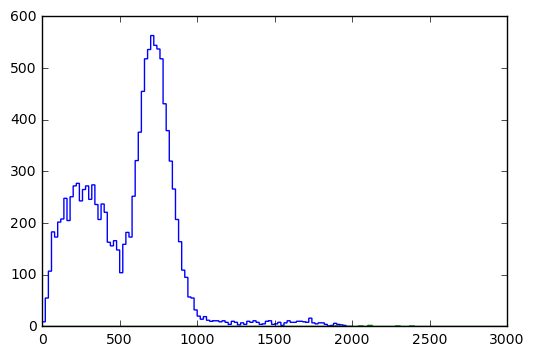

In [269]:
plt.hist(d_cs['s1_area'], bins=100, histtype='step', range=(0, 2000))
plt.hist(d_cs[d_cs['s1_n_saturated_channels'] > 0]['s1_area'], bins=100, histtype='step', range=(0, 3000))
plt.show()

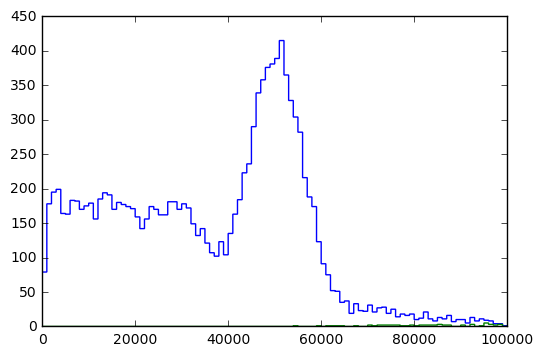

In [270]:
plt.hist(d_cs['s2_area'], bins=100, histtype='step', range=(0, 100000))
plt.hist(d_cs[d_cs['s2_n_saturated_channels'] > 0]['s2_area'], bins=100, 
         histtype='step', range=(0, 100000))
plt.show()

### S1S2 scatter

In [271]:
len(d_cs)

12778

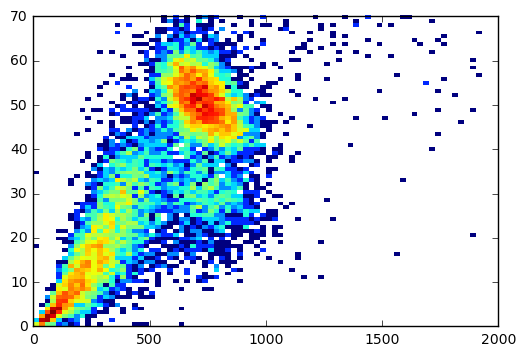

In [274]:
plt.hist2d(d_cs['s1_area'], d_cs['s2_area']*1e-3, 
           bins=80, 
           norm=LogNorm(), range=((0,2000), (0, 70)))
plt.show()

(0, 70)

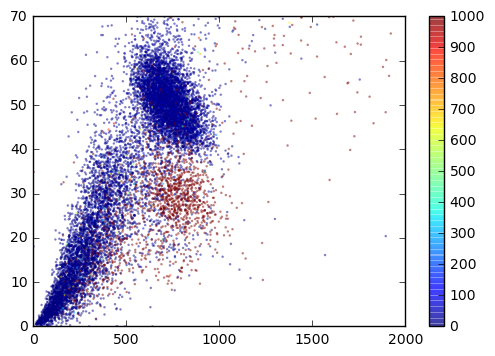

In [273]:
plt.scatter(d_cs['s1_area'], d_cs['s2_area']*1e-3, edgecolor='none', s=3, alpha=0.5, c=d_cs['largest_other_s2'],
           vmax=1000)
plt.colorbar()
plt.xlim(0,2000)
plt.ylim(0,70)

In [275]:
d_cs = cuts.below(d_cs, 'largest_other_s2', 1000)

largest_other_s2 below 1000 selection: 1653 rows removed (87.06% passed)


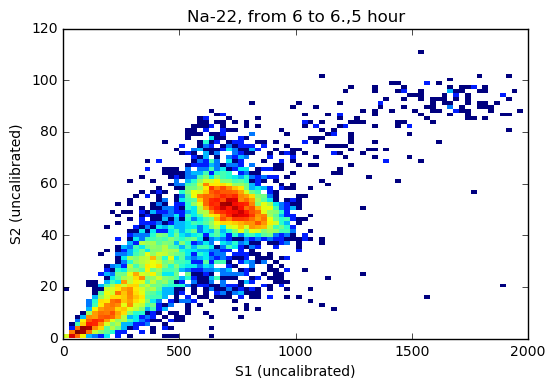

In [281]:
plt.hist2d(d_cs['s1_area'], d_cs['s2_area']*1e-3, bins=80, 
           norm=LogNorm(), range=((0,2000), (0, 120)))
plt.xlabel('S1 (uncalibrated)')
plt.ylabel('S2 (uncalibrated)')
plt.title('Na-22, from 6 to 6.,5 hour')
plt.savefig('170310_s1s2_na22.png', bbox_inches='tight')
plt.show()